In [1]:
from lbmpy.session import *

# Tutorial 04: The Cumulant Lattice Boltzmann Method in lbmpy

## A) Principles of the centered cumulant collision operator

Recently, an advanced Lattice Boltzmann collision operator based on relaxation in cumulant space has gained popularity. Similar to moments, cumulants are statistical quantities inherent to a probability distribution. A significant advantage of the cumulants is that they are statistically independent by construction. Moments can be defined by using the so-called moment generating function, which for the discrete particle distribution of the LB equation is stated as

$$
\begin{align}
    M( \mathbf{X} ) = 
    \sum_i f_i 
    \exp \left(
        \mathbf{c}_i \cdot \mathbf{X}
    \right)
\end{align}
$$

The raw moments $m_{\alpha \beta \gamma}$ can be expressed as its derivatives, evaluated at zero:

$$
\begin{align}
    m_{\alpha \beta \gamma} 
    = 
    \left.
    \frac{\partial^{\alpha}}{\partial X^{\alpha}}
    \frac{\partial^{\beta}}{\partial Y^{\beta}}
    \frac{\partial^{\gamma}}{\partial Z^{\gamma}}
    M(X, Y, Z) 
    \right\vert_{\mathbf{X}=0}
\end{align}
$$

The cumulant-generating function is defined as the natural logarithm of this moment-generating function, and the cumulants $c_{\alpha \beta \gamma}$ are defined as its derivatives evaluated at zero:

$$
\begin{align}
    C(\mathbf{X}) :=& \, \log ( M(\mathbf{X}) ) \\
    c_{\alpha \beta \gamma} 
    =& \,
    \left.
    \frac{\partial^{\alpha}}{\partial X^{\alpha}}
    \frac{\partial^{\beta}}{\partial Y^{\beta}}
    \frac{\partial^{\gamma}}{\partial Z^{\gamma}}
    C(X, Y, Z) 
    \right\vert_{\mathbf{X}=0}
\end{align}
$$

Other than with moments, there is no straightforward way to express cumulants in terms of the populations. However, their generating functions can be related to allowing the computation of cumulants from both raw and central moments, computed from populations. In lbmpy, the transformations from populations to cumulants and back are implemented using central moments as intermediaries. This is done for two primary reasons:
 1. All cumulants of orders 2 and 3 are equal to their corresponding central moments, up to the density $\rho$ as a proportionality factor.
 2. The conserved modes of the first order, which correspond to momentum, are relaxed in central moment space to allow for a more efficient implicit forcing scheme.

The central moment-generating function $K$ can be related to the moment-generating function through $K(\mathbf{X}) = \exp( - \mathbf{X} \cdot \mathbf{u} ) M(\mathbf{X})$. It is possible to recombine the equation with the definition of the cumulant-generating function

$$
\begin{align}
    C( \mathbf{X} ) = \mathbf{X} \cdot \mathbf{u} + \log( K( \mathbf{X} ) ).
\end{align}
$$

Derivatives of $C$ can thus be expressed in terms of derivatives of $K$, directly yielding equations of the cumulants in terms of central moments.

In the cumulant collision operator, forces can be applied through a simple forcing scheme which in lbmpy is called *implicit forcing*. Ony the force contributions to the first-order (momentum) modes are considered. When the first-order central moments are taken in the frame of reference shifted by $F/2$, they trail behind zero by just that much. Forcing can be applied by first adding half the force *before* collision, and then adding the remaining half *after* collision. Due to this, the first-order central moments entering the cumulant equations are always zero. By applying the force already in central-moment space, the cumulant equations are simplified significantly as no forces need to be taken into account. The pre- and post-collision momentum central moments take the form:

$$
\begin{align}
    \kappa_{100} &= - \frac{F_x}{2}, \\ 
    \kappa^{\ast}_{100} &= \kappa_{100} + F_x = \frac{F_x}{2}
\end{align}
$$

In total, through forcing, the first central moments change sign. This is equivalent to relaxation with a relaxation rate $\omega = 2$. For this reason, lbmpy's implementation of the cumulant LBM calculates the collision of the momentum modes in central moment space, and the default force model overrides their relaxation rate by setting it to 2.

## B) Method Creation

Using the `create_lb_method` interface, creation of a cumulant-based lattice Boltzmann method in lbmpy is straightforward. Cumulants can either be relaxed in their raw (monomial forms) or in polynomial combinations. Both variants are available as predefined setups. **Attention:** Cumulant-based methods are only available for the *compressible* equilibrium.

### Relaxation of Monomial Cumulants

Monomial cumulant relaxation is available through the `method="monomial_cumulant"` parameter setting. This variant requires fewer transformation steps and is a little faster than polynomial relaxation, but it does not allow separation of bulk and shear viscosity. Default monomial cumulant sets are available for the D2Q9, D3Q19 and D3Q27 stencils. It is also possible to define a custom set of monomial cumulants.

When creating a monomial cumulant method, one option is to specify only a single relaxation rate which will then be assigned to all cumulants related to the shear viscosity. In this case, all other non-conserved cumulants will be relaxed to equilibrium. Alternatively, individual relaxation rates for all non-conserved cumulants can be specified. The conserved cumulants are set to zero by default to save computational cost. They can be adjusted with `set_zeroth_moment_relaxation_rate`, `set_first_moment_relaxation_rate` and `set_conserved_moments_relaxation_rate`.

In [2]:
lbm_config = LBMConfig(method=Method.MONOMIAL_CUMULANT, relaxation_rate=sp.Symbol('omega_v'), compressible=True)
method_monomial = create_lb_method(lbm_config=lbm_config)
method_monomial

### Relaxation of Polynomial Cumulants

By setting `method="cumulant"`, a set of default polynomial cumulants is chosen to be relaxed. Those cumulants are taken from literature and assembled into groups selected to enforce rotational invariance (see: `lbmpy.methods.centeredcumulant.centered_cumulants`). Default polynomial groups are available for the D2Q9, D3Q19 and D3Q27 stencils. As before it is possible to specify only a single relaxation rate assigned to the moments governing the shear viscosity. All other relaxation rates are then automatically set to one.

In [3]:
lbm_config = LBMConfig(method=Method.CUMULANT, relaxation_rate=sp.Symbol('omega_v'), compressible=True)
method_polynomial = create_lb_method(lbm_config=lbm_config)
method_polynomial

### Central Moments and Forcing

The conserved modes are marked with the note *(central moment)* in the table above. It highlights the fact that these modes are relaxed in central moment space, other than cumulant space. As described in section A, this is done to enable the implicit forcing scheme. When a force is specified, the momentum modes' relaxation rates are overridden by the force model. In the following cell, a symbolic force is specified. Further, a full list of relaxation rates is passed to allow the specification of bulk viscosity.

In [4]:
lbm_config = LBMConfig(method=Method.CUMULANT, force=sp.symbols('F_:3'), compressible=True,
                       relaxation_rates= [sp.Symbol('omega_shear'),
                                          sp.Symbol('omega_bulk'),
                                          sp.Symbol('omega_3'),
                                          sp.Symbol('omega_4')])
method_with_force = create_lb_method(lbm_config=lbm_config)
method_with_force

## C) Exemplary simulation: flow around sphere

To end this tutorial, we show an example simulation of a channel flow with a spherical obstacle. This example is shown in 2D with the D2Q9 stencil but can be adapted easily for a 3D simulation.

In [5]:
from lbmpy.relaxationrates import relaxation_rate_from_lattice_viscosity
from lbmpy.macroscopic_value_kernels import pdf_initialization_assignments

To define the channel flow with dimensionless parameters, we first define the reference length in lattice cells. The reference length will be the diameter of the spherical obstacle. Furthermore, we define a maximal velocity which will be set for the inflow later. The Reynolds number is set relatively high to 100000, which will cause a turbulent flow in the channel.

From these definitions, we can calculate the relaxation rate `omega` for the lattice Boltzmann method.

In [6]:
reference_length = 30
maximal_velocity = 0.05
reynolds_number = 100000
kinematic_vicosity = (reference_length * maximal_velocity) / reynolds_number
initial_velocity=(maximal_velocity, 0)

omega = relaxation_rate_from_lattice_viscosity(kinematic_vicosity)

As a next step, we define the domain size of our set up.

In [7]:
stencil = LBStencil(Stencil.D2Q9)
domain_size = (reference_length * 12, reference_length * 4)
dim = len(domain_size)

Now the data for the simulation is allocated. We allocate a field `src` for the PDFs and field `dst` used as a temporary field to implement the two grid pull pattern. Additionally, we allocate a velocity field `velField`

In [8]:
dh = ps.create_data_handling(domain_size=domain_size, periodicity=(False, False))

src = dh.add_array('src', values_per_cell=len(stencil), alignment=True)
dh.fill('src', 0.0, ghost_layers=True)
dst = dh.add_array('dst', values_per_cell=len(stencil), alignment=True)
dh.fill('dst', 0.0, ghost_layers=True)

velField = dh.add_array('velField', values_per_cell=dh.dim, alignment=True)
dh.fill('velField', 0.0, ghost_layers=True)

We choose a cumulant lattice Boltzmann method, as described above. Here the second-order cumulants are relaxed with the relaxation rate calculated above. All higher-order cumulants are relaxed with one, which means we set them to the equilibrium.

In [9]:
lbm_config = LBMConfig(stencil=Stencil.D2Q9, method=Method.CUMULANT, relaxation_rate=omega,
                       compressible=True,
                       output={'velocity': velField}, kernel_type='stream_pull_collide')

method = create_lb_method(lbm_config=lbm_config)
method

### Initialisation with equilibrium

In [10]:
init = pdf_initialization_assignments(method, 1.0, initial_velocity, src.center_vector)

ast_init = ps.create_kernel(init, target=dh.default_target)
kernel_init = ast_init.compile()

dh.run_kernel(kernel_init)

### Definition of the update rule

In [11]:
lbm_optimisation = LBMOptimisation(symbolic_field=src, symbolic_temporary_field=dst)
update = create_lb_update_rule(lb_method=method,
                               lbm_config=lbm_config,
                               lbm_optimisation=lbm_optimisation)

ast_kernel = ps.create_kernel(update, target=dh.default_target, cpu_openmp=True)
kernel = ast_kernel.compile()

### Definition of the boundary set up

In [12]:
def set_sphere(x, y, *_):
    mid = (domain_size[0] // 3, domain_size[1] // 2)
    radius = reference_length // 2
    return (x-mid[0])**2 + (y-mid[1])**2 < radius**2

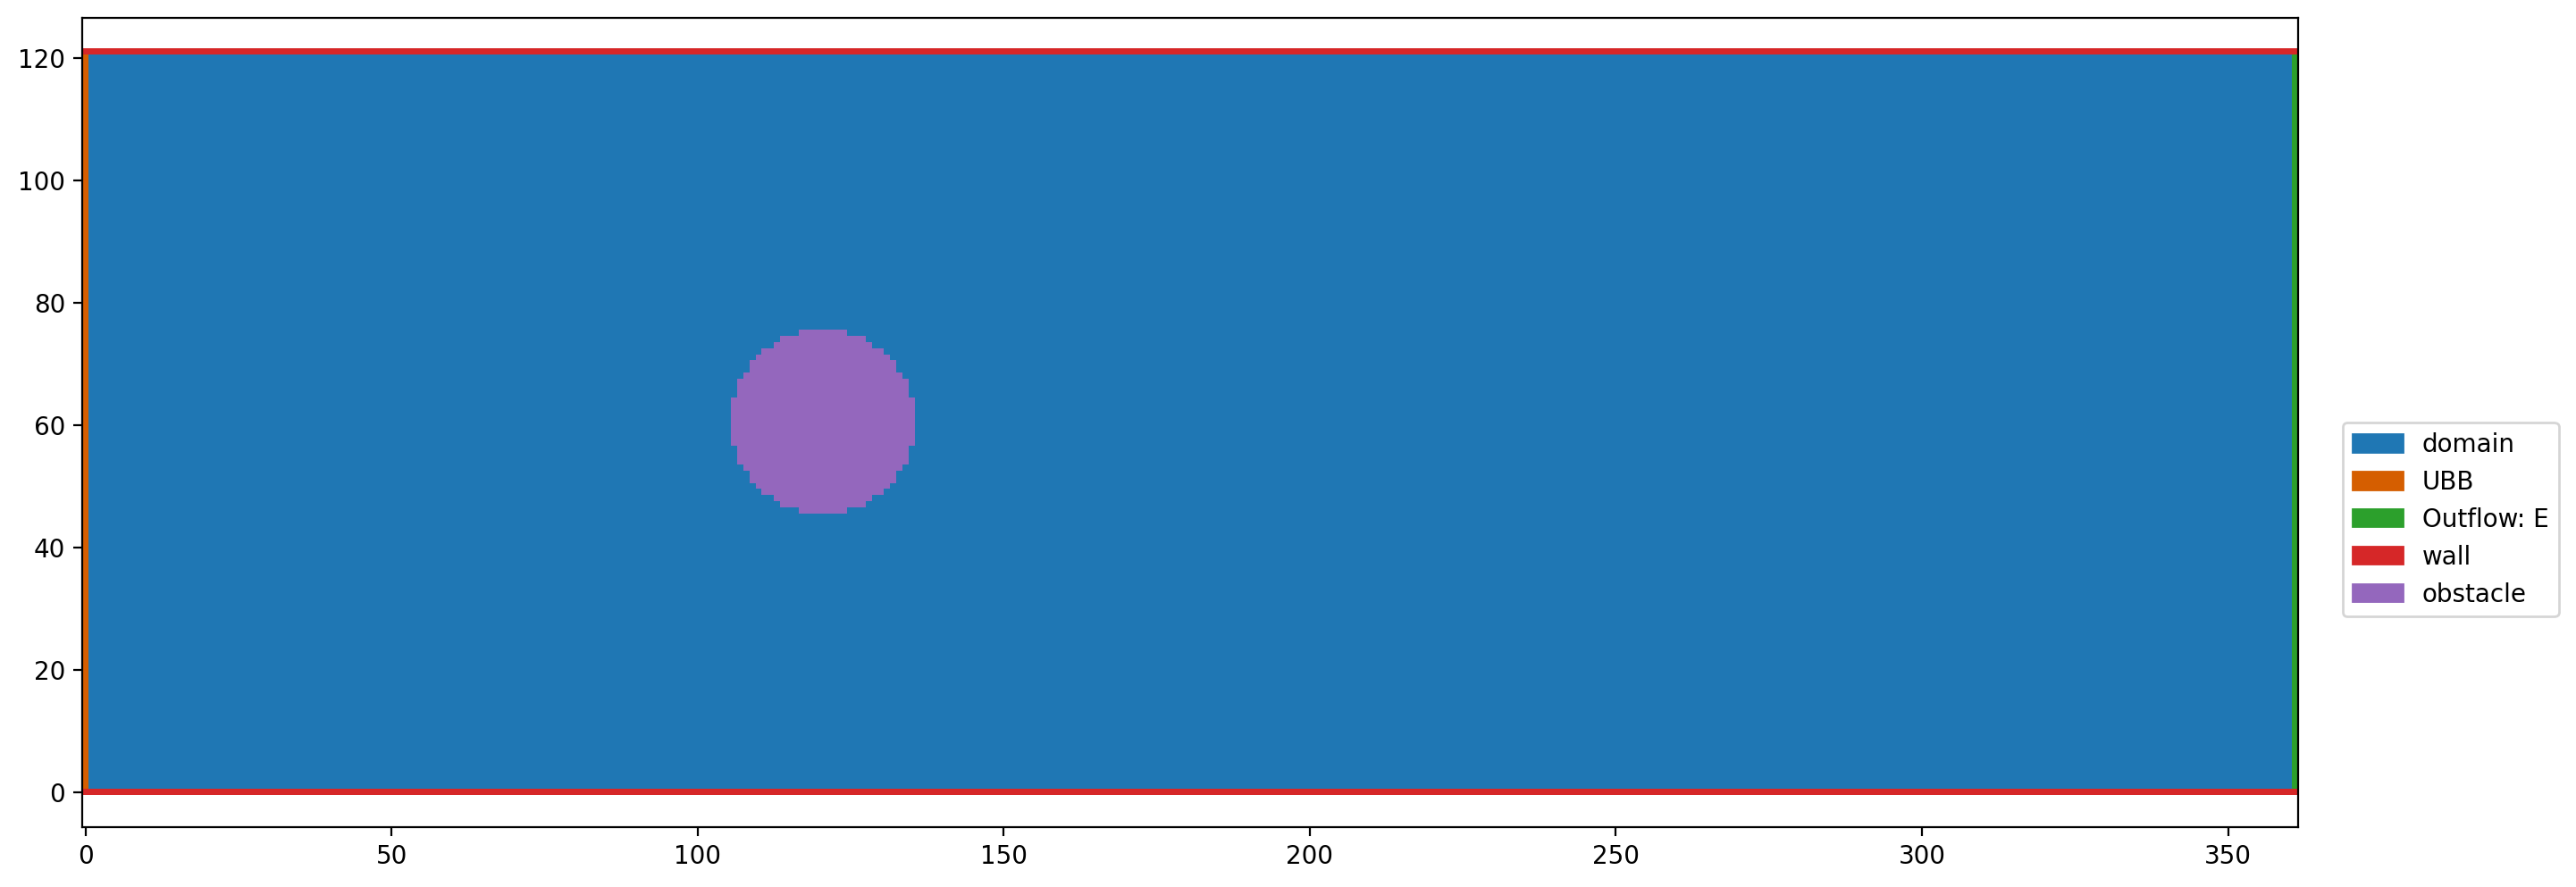

In [13]:
bh = LatticeBoltzmannBoundaryHandling(method, dh, 'src', name="bh")

inflow = UBB(initial_velocity)
outflow = ExtrapolationOutflow(stencil[4], method)
wall = NoSlip("wall")

bh.set_boundary(inflow, slice_from_direction('W', dim))
bh.set_boundary(outflow, slice_from_direction('E', dim))
for direction in ('N', 'S'):
    bh.set_boundary(wall, slice_from_direction(direction, dim))

bh.set_boundary(NoSlip("obstacle"), mask_callback=set_sphere)

plt.figure(dpi=200)
plt.boundary_handling(bh)

In [14]:
def timeloop(timeSteps):
    for i in range(timeSteps):
        bh()
        dh.run_kernel(kernel)
        dh.swap("src", "dst")

### Run the simulation

In [15]:
mask = np.fromfunction(set_sphere, (domain_size[0], domain_size[1], len(domain_size)))
if 'is_test_run' not in globals():
    timeloop(50000)  # initial steps

    def run():
        timeloop(100)
        return np.ma.array(dh.gather_array('velField'), mask=mask)

    animation = plt.vector_field_magnitude_animation(run, frames=600, rescale=True)
    set_display_mode('video')
    res = display_animation(animation)
else:
    timeloop(10)
    res = None
res